In [18]:
import os
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [19]:
log_dir = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/logs'

log_file_list = os.listdir(log_dir)
log_file_list[:3]

['5989092.out', '5368722.out', '6191961.out']

In [20]:
#added _short5 to end of file name to indicate short context, not there in the original file name
#
# config_to_log_dict = {
# "train_blmf_8k_2x2_gpt_exp010.py":5983308,
# "train_blmf_8k_4x4_gpt_exp010.py":5988018,
# "train_blmf_8k_6x6_gpt_exp010.py":5734465,
# "train_blmf_8k_8x8_gpt_exp010.py":5988020,
# "train_blmf_8k_12x12_gpt_exp010.py":5989080,
# "train_blmf_8k_2x2_gpt_exp100.py":5983309,
# "train_blmf_8k_4x4_gpt_exp100.py":5988019,
# "train_blmf_8k_6x6_gpt_exp100.py":5734467,
# "train_blmf_8k_8x8_gpt_exp100.py":5988022,
# "train_blmf_8k_12x12_gpt_exp100.py":5989082,
# "train_blmf_8k_2x2_gpt_exp010_short5.py":5988063,
# "train_blmf_8k_4x4_gpt_exp010_short5.py":5990491,
# "train_blmf_8k_6x6_gpt_exp010_short5.py":5990493,
# "train_blmf_8k_8x8_gpt_exp010_short5.py":5990495,
# "train_blmf_8k_12x12_gpt_exp010_short5.py":5990497,
# "train_blmf_8k_2x2_gpt_exp100_short5.py":5988064,
# "train_blmf_8k_4x4_gpt_exp100_short5.py":5990492,
# "train_blmf_8k_6x6_gpt_exp100_short5.py":5990494,
# "train_blmf_8k_8x8_gpt_exp100_short5.py":5990496,
# "train_blmf_8k_12x12_gpt_exp100_short5.py":5990498,
# "train_blmf_8k_6x12_5gramgpt_nomask.py":6067324,
# "train_blmf_8k_12x12_5gramgpt_nomask.py":6067325,
# "train_blmf_8k_16x12_5gramgpt_nomask.py":6067326,
# "train_blmf_8k_6x6_5gramgpt_nomask.py":5988065,
# "train_blmf_8k_12x6_5gramgpt_nomask.py":6067525,
# "train_blmf_8k_16x6_5gramgpt_nomask.py":6074706,
# "train_blmf_8k_24x12_5gramgpt_nomask.py":6076155,
# "train_blmf_8k_6x12_gpt_exp100_short5.py":6076156,
# "train_blmf_8k_16x12_gpt_exp100_short5.py":6076157,
# "train_blmf_8k_24x12_gpt_exp100_short5.py":6076158,
# "train_blmf_8k_2x12_5gramgpt_nomask.py":6093007,
# "train_blmf_8k_2x12_gpt_exp100_short5.py":6093011,
# "train_blmf_8k_4x12_5gramgpt_nomask.py":6093010,
# "train_blmf_8k_4x12_gpt_exp100_short5.py":6093012,
#
# "train_blmf_8k_2x12_gpt_exp100_short5_ffwadjp.py":6156974,
# "train_blmf_8k_4x12_gpt_exp100_short5_ffwadjp.py":6156975,
# "train_blmf_8k_6x12_gpt_exp100_short5_ffwadjp.py":6156976,
# "train_blmf_8k_12x12_gpt_exp100_short5_ffwadjp.py":5990498,
# "train_blmf_8k_16x12_gpt_exp100_short5_ffwadjp.py":6156977,
#
#
# "train_blmf_8k_2x12_gpt_exp100_short5_hsadjp.py":6155194,
# "train_blmf_8k_4x12_gpt_exp100_short5_hsadjp.py":6155195,
# "train_blmf_8k_6x12_gpt_exp100_short5_hsadjp.py":6155196,
# "train_blmf_8k_12x12_gpt_exp100_short5_hsadjp.py":5990498,
# "train_blmf_8k_16x12_gpt_exp100_short5_hsadjp.py":6155197,
#
#
#
# }
#
#
#
# inverse_config_to_log_dict = {v: k for k, v in config_to_log_dict.items()}

In [21]:
# pd.DataFrame.from_dict(config_to_log_dict, orient='index', columns=['run_UID']).reset_index().rename(columns={'index': 'config_file_name'}).to_csv('config_to_log_dict.csv', index=False)


csv_file = 'config_to_log_dict.csv'
config_to_log_dict = pd.read_csv(csv_file).set_index('config_file_name').to_dict()['run_UID']
inverse_config_to_log_dict = {v: k for k, v in config_to_log_dict.items()}
#config_to_log_dict


In [22]:
data_dict_list = []

for file_name, log_unique_id in config_to_log_dict.items():
    #print(file_name, log_unique_id)
    data_dict = {}
    data_dict['file_name'] = file_name
    data_dict['log_unique_id'] = log_unique_id
    data_dict["size"] = file_name.split('_')[3]
    data_dict["mask_size"] = file_name.split('_')[5].split('.')[0]
    data_dict["context_type"] = "short" if "short" in file_name or "gram" in file_name else "long"

    parts = [part.split(".")[0] for part in file_name.split("_") if "adj" in part]
    data_dict["params_adj"] = parts[0] if parts else "no_adj"

    tpi_set = False
    nop_set = False
    with open(os.path.join(log_dir, str(log_unique_id) + '.out'), 'r') as f:
        flines = f.readlines()
        for file_line in flines:
            if "tokens per iteration" in file_line:
                data_dict["tokens_per_iteration"] = file_line.split(':')[-1].strip()
                tpi_set = True
            elif "number of parameters" in file_line:
                data_dict["number_of_parameters"] = file_line.split(':')[-1].strip()
                nop_set = True
            if tpi_set and nop_set:
                break
    data_dict_list.append(data_dict)

data_dict_df = pd.DataFrame(data_dict_list)
data_dict_df.head()

,file_name,log_unique_id,size,mask_size,context_type,params_adj,tokens_per_iteration,number_of_parameters
0,train_blmf_8k_2x2_gpt_exp010.py,5983308,2x2,exp010,long,no_adj,"65,536",6.61M
1,train_blmf_8k_4x4_gpt_exp010.py,5988018,4x4,exp010,long,no_adj,"65,536",10.15M
2,train_blmf_8k_6x6_gpt_exp010.py,5734465,6x6,exp010,long,no_adj,"65,536",13.69M
3,train_blmf_8k_8x8_gpt_exp010.py,5988020,8x8,exp010,long,no_adj,"65,536",17.23M
4,train_blmf_8k_12x12_gpt_exp010.py,5989080,12x12,exp010,long,no_adj,"65,536",24.32M


In [23]:
api = wandb.Api()
luid = "babylm_full_bpe_8k_6x6_nomask_gpt2_server_run_6092910_2gramadj"
run = api.runs(path="abishekthamma/wikipedia", filters={"config.wandb_run_name": {"$regex": f"{luid}"}})



In [26]:
def verify_run_data(run, log_id):
    with open(os.path.join(log_dir, str(log_id) + '.out'), 'r') as f:
        flines = f.readlines()
        run_complete = False
        for i, file_line in enumerate(flines):
            if i == 1:
                if "Overriding config with" in file_line:
                    #print(file_line)
                    config_name_full_logs = file_line.split(" ")[-1]
                    config_name_logs = config_name_full_logs.split("/")[-1]
                    dataset_folder_logs = config_name_full_logs.split("/")[0]
                    mask_type = [x for x in config_name_logs.split("_") if "mask" in x or "exp" in x or "lin" in x][0]
                    mask_type = {"exp100":"e100", "exp010":"e010", "lin":"lin", "nomask":"nomask", "exp250":"e250"}[mask_type.split(".")[0]]
                    if "multiseed" in config_name_logs:
                        seeding = "multi_seed"
                        seed_num = {1:42, 2:1729, 3:31415, 4:404, 5:101010}[int(config_name_logs.split("_")[-1].split(".")[0])]
                    else:
                        seeding = "single_seed"

                    if "short" in config_name_logs:
                        context_type = "short"
                    else:
                        context_type = "long"

                    logs_n_layer = int(config_name_logs.split("_")[3].split("x")[0])
                    logs_n_head = int(config_name_logs.split("_")[3].split("x")[1])
                    if "ffw_adj" in config_name_logs:
                        adj_type = "ffw_adj"
                    elif "hs_adj" in config_name_logs:
                        adj_type = "hs_adj"
                    else:
                        adj_type = "no_adj"

                else:
                    print("No config override")
                    raise ValueError("No config override")

            else:
                #Check if run is complete
                if "iter 44000" in file_line:
                    run_completed = True

        if not run_completed:
            #print(f"Run {log_id} did not complete")
            raise ValueError(f"Run {log_id} did not complete")

    assert run.config.get("n_layer") == logs_n_layer, f"Run {log_id} n_layer mismatch, {run.config.get('n_layer')} != {logs_n_layer}"
    assert run.config.get("n_head") == logs_n_head, f"Run {log_id} n_head mismatch, {run.config.get('n_head')} != {logs_n_head}"
    if seeding == "multi_seed":
        assert run.config.get("torch_seed_default") == seed_num

    if adj_type == "ffw_adj":
        assert "ffwadjp" in run.config.get("out_dir")
    elif adj_type == "hs_adj":
        assert "hsadjp" in run.config.get("out_dir")

    assert mask_type in run.config.get("out_dir"), f"Run {log_id} mask type mismatch, {mask_type} not in {run.config.get('out_dir')}"


In [27]:
api = wandb.Api()
wandb_run_data = {}
start_time = time.time()
for luid in data_dict_df['log_unique_id']:
    run = api.runs(path="abishekthamma/wikipedia", filters={"config.wandb_run_name": {"$regex": f"{luid}"}})
    run = list(run)
    if len(run) > 1:
        raise ValueError("More than one run found")
    else:
        run = run[0]
    verify_run_data(run, luid)
    wandb_run_data[luid] = {
        "train_loss": run.summary.get("train/loss"),
        "val_loss": run.summary.get("val/loss"),
        "n_layer": run.config.get("n_layer"),
        "block_size": run.config.get("block_size"),
        "n_head": run.config.get("n_head"),
        "n_embd": run.config.get("n_embd"),
        "batch_size": run.config.get("batch_size"),
        "learning_rate": run.config.get("learning_rate"),
        "dataset": run.config.get("dataset"),
        "output_dir": run.config.get("out_dir"),
        "torch_seed_default": run.config.get("torch_seed_default"),
    }
print(f"Time taken: {time.time() - start_time}")


Time taken: 18.397780656814575


In [28]:
wandb_run_data[5983308]

{'train_loss': 3.4359242916107178,
 'val_loss': 3.951026678085327,
 'n_layer': 2,
 'block_size': 256,
 'n_head': 2,
 'n_embd': 384,
 'batch_size': 32,
 'learning_rate': 0.0005,
 'dataset': 'babylm_full_bpe_8k',
 'output_dir': 'output_dump/out-babylm_full_bpe_8k-2x2-mask_e010-5983308',
 'torch_seed_default': 1337}

In [29]:
wandb_run_df = pd.DataFrame(wandb_run_data).T
wandb_run_df.head()

,train_loss,val_loss,n_layer,block_size,n_head,n_embd,batch_size,learning_rate,dataset,output_dir,torch_seed_default
5983308,3.435924,3.951027,2,256,2,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-2x2-mask_e0...,1337
5988018,3.102483,3.843051,4,256,4,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-4x4-mask_e0...,1337
5734465,2.882256,3.860461,6,256,6,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-6x6-mask_e0...,1337
5988020,2.683279,3.979754,8,256,8,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-8x8-mask_e0...,1337
5989080,2.304901,4.179955,12,256,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-12x12-mask_...,1337


In [30]:
data_dict_df = data_dict_df.join(wandb_run_df, on='log_unique_id').set_index("log_unique_id")

In [31]:
data_dict_df[(data_dict_df['context_type']=='short') & (data_dict_df["mask_size"] != 'exp010') & (data_dict_df["torch_seed_default"] == 42)]

,file_name,size,mask_size,context_type,params_adj,tokens_per_iteration,number_of_parameters,train_loss,val_loss,n_layer,block_size,n_head,n_embd,batch_size,learning_rate,dataset,output_dir,torch_seed_default
log_unique_id,,,,,,,,,,,,,,,,,,
6191973,train_blmf_8k_2x12_gpt_exp100_short5_hsadjp_ms...,2x12,exp100,short,hsadjp,"1,280",24.31M,4.716504,4.857531,2,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-2x12-mask_e...,42
6191974,train_blmf_8k_4x12_gpt_exp100_short5_hsadjp_ms...,4x12,exp100,short,hsadjp,"1,280",24.31M,4.654302,4.811798,4,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-4x12-mask_e...,42
6191975,train_blmf_8k_6x12_gpt_exp100_short5_hsadjp_ms...,6x12,exp100,short,hsadjp,"1,280",24.31M,4.620311,4.845115,6,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-6x12-mask_e...,42
6191976,train_blmf_8k_12x12_gpt_exp100_short5_hsadjp_m...,12x12,exp100,short,hsadjp,"1,280",24.32M,4.587596,4.765815,12,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-12x12-mask_...,42
6200055,train_blmf_8k_2x12_5gramgpt_nomask_hsadjp_ms1.py,2x12,nomask,short,hsadjp,"1,280",24.31M,4.712198,4.852012,2,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-2x12-nomask...,42
6200060,train_blmf_8k_4x12_5gramgpt_nomask_hsadjp_ms1.py,4x12,nomask,short,hsadjp,"1,280",24.31M,4.648597,4.81072,4,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-4x12-nomask...,42
6200065,train_blmf_8k_6x12_5gramgpt_nomask_hsadjp_ms1.py,6x12,nomask,short,hsadjp,"1,280",24.31M,4.615416,4.827072,6,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-6x12-nomask...,42
6200071,train_blmf_8k_12x12_5gramgpt_nomask_hsadjp_ms1.py,12x12,nomask,short,hsadjp,"1,280",24.32M,4.576005,4.758681,12,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-12x12-nomas...,42
6199955,train_blmf_8k_2x12_5gramgpt_nomask_ms1.py,2x12,nomask,short,no_adj,"1,280",6.61M,4.72325,4.861381,2,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-2x12-nomask...,42


In [32]:
data_dict_df

,file_name,size,mask_size,context_type,params_adj,tokens_per_iteration,number_of_parameters,train_loss,val_loss,n_layer,block_size,n_head,n_embd,batch_size,learning_rate,dataset,output_dir,torch_seed_default
log_unique_id,,,,,,,,,,,,,,,,,,
5983308,train_blmf_8k_2x2_gpt_exp010.py,2x2,exp010,long,no_adj,"65,536",6.61M,3.435924,3.951027,2,256,2,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-2x2-mask_e0...,1337
5988018,train_blmf_8k_4x4_gpt_exp010.py,4x4,exp010,long,no_adj,"65,536",10.15M,3.102483,3.843051,4,256,4,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-4x4-mask_e0...,1337
5734465,train_blmf_8k_6x6_gpt_exp010.py,6x6,exp010,long,no_adj,"65,536",13.69M,2.882256,3.860461,6,256,6,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-6x6-mask_e0...,1337
5988020,train_blmf_8k_8x8_gpt_exp010.py,8x8,exp010,long,no_adj,"65,536",17.23M,2.683279,3.979754,8,256,8,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-8x8-mask_e0...,1337
5989080,train_blmf_8k_12x12_gpt_exp010.py,12x12,exp010,long,no_adj,"65,536",24.32M,2.304901,4.179955,12,256,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-12x12-mask_...,1337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6225033,train_blmf_8k_4x12_5gramgpt_nomask_hsadjp_ms2.py,4x12,nomask,short,hsadjp,"1,280",24.31M,4.678602,4.827427,4,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-4x12-nomask...,1729
6225034,train_blmf_8k_6x12_5gramgpt_nomask_hsadjp_ms3.py,6x12,nomask,short,hsadjp,"1,280",24.31M,4.661657,4.798996,6,5,12,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-6x12-nomask...,31415
5734550,train_blmf_8k_6x6_gpt_exp250.py,6x6,exp250,long,no_adj,"65,536",13.69M,3.096329,4.095433,6,256,6,384,32,0.0005,babylm_full_bpe_8k,output_dump/out-babylm_full_bpe_8k-6x6-mask_e2...,1337


In [45]:
model_list = {
    5734459:'babylm_full_bpe_8k',
    5734550: "babylm_full_bpe_8k",
    5496427: "babylm_full_bpe_8k",
}

#plot validation loss for list of models in model_list


plot_data = data_dict_df[data_dict_df.index.isin(model_list.keys())]["val_loss"]
plt.bar(
plt.xlabel('Model Size')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Model Sizes')
plt.legend()
#print(plot_data)
plt.show()
    
    
    



TypeError: bar() missing 1 required positional argument: 'height'

In [42]:
model_list.keys()

dict_keys([5734459, 5734550, 5496427])

In [13]:
import numpy as np

model_sizes = ['2x12', '4x12', '6x12', '12x12']

#just filter for specific model sizes
filter_data_df = data_dict_df[data_dict_df['size'].isin(model_sizes)]
filter_data_df['size'] = pd.Categorical(filter_data_df['size'], model_sizes)
filter_data_df = filter_data_df.sort_values('size')


#setting 1: No Mask, no adjusted parameters, short context
setting1_data = filter_data_df[(filter_data_df['mask_size'] == 'nomask') & (filter_data_df['params_adj'] == 'no_adj')]

#Setting 2: No Mask, adjusted parameters (hsadjp), short context
setting2_data = filter_data_df[(filter_data_df['mask_size'] == 'nomask') & (filter_data_df['params_adj'] == 'hsadjp')]

#setting 3: E100 mask with HS adj, short context
setting3_data = filter_data_df[(filter_data_df['mask_size'] == 'exp100') & (filter_data_df['params_adj'] == 'hsadjp')]


setting1_td = setting1_data[["size", "train_loss", "torch_seed_default"]].reset_index(drop=True)
setting1_vd = setting1_data[["size", "val_loss","torch_seed_default"]].reset_index(drop=True)
setting1_td = setting1_td.pivot(columns='torch_seed_default', values='train_loss', index='size')
setting1_vd = setting1_vd.pivot(columns='torch_seed_default', values='val_loss', index='size')
setting1_td_arr = setting1_td.to_numpy(dtype=np.float64)
setting1_vd_arr = setting1_vd.to_numpy(dtype=np.float64)


setting2_td = setting2_data[["size", "train_loss", "torch_seed_default"]].reset_index(drop=True)
setting2_vd = setting2_data[["size", "val_loss","torch_seed_default"]].reset_index(drop=True)
setting2_td = setting2_td.pivot(columns='torch_seed_default', values='train_loss', index='size')
setting2_vd = setting2_vd.pivot(columns='torch_seed_default', values='val_loss', index='size')
setting2_td_arr = setting2_td.to_numpy(dtype=np.float64)
setting2_vd_arr = setting2_vd.to_numpy(dtype=np.float64)

setting3_td = setting3_data[["size", "train_loss", "torch_seed_default"]].reset_index(drop=True)
setting3_vd = setting3_data[["size", "val_loss","torch_seed_default"]].reset_index(drop=True)
setting3_td = setting3_td.pivot(columns='torch_seed_default', values='train_loss', index='size')
setting3_vd = setting3_vd.pivot(columns='torch_seed_default', values='val_loss', index='size')
setting3_td_arr = setting3_td.to_numpy(dtype=np.float64)
setting3_vd_arr = setting3_vd.to_numpy(dtype=np.float64)



# mean_losses = setting1_vd_arr.mean(axis=1)
# std_losses = setting1_vd_arr.std(axis=1)
#
# # Plotting
# plt.errorbar(model_sizes, mean_losses, yerr=std_losses, fmt='o-', capsize=5)
# plt.xlabel('Model Size')
# plt.ylabel('Validation Loss')
# plt.title('Validation Loss for Different Model Sizes')
# plt.grid(True)
# plt.show()

/tmp/ipykernel_868391/1418858670.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data_df['size'] = pd.Categorical(filter_data_df['size'], model_sizes)


In [14]:
print(setting1_td_arr)
#print(setting2_td_arr)
#print(setting3_td_arr)
print("\n")
print(setting1_vd_arr)
#print(setting2_vd_arr[0])
#print(setting3_vd_arr[0])


print("\n")
print(setting1_vd_mean)
print(setting1_vd_std)

[[4.72325039 4.70733786 4.72345257 4.72122335 4.69898272]
 [4.69184923 4.67461109 4.68283749 4.67078686 4.68574286]
 [4.65838909 4.66623974 4.64707756 4.63868046 4.6504097 ]
 [4.57544756 4.61156321 4.61139059 4.6208396  4.59355831]]


[[4.86138105 4.86468887 4.89136362 4.90204334 4.84931564]
 [4.83805704 4.8466258  4.82644272 4.85266542 4.83609104]
 [4.81933641 4.82977915 4.80970955 4.83835363 4.83485413]
 [4.75830698 4.77523518 4.78414536 4.8054738  4.79570818]]




NameError: name 'setting1_vd_mean' is not defined

In [15]:
(4.86138105+4.86468887+4.89136362+4.90204334+4.84931564)/5

4.8737585039999995

In [16]:
k1 = [4.86138105,4.86468887,4.89136362,4.90204334,
      4.84931564]
np.mean(k1)
np.std(k1)

0.019712357981017226

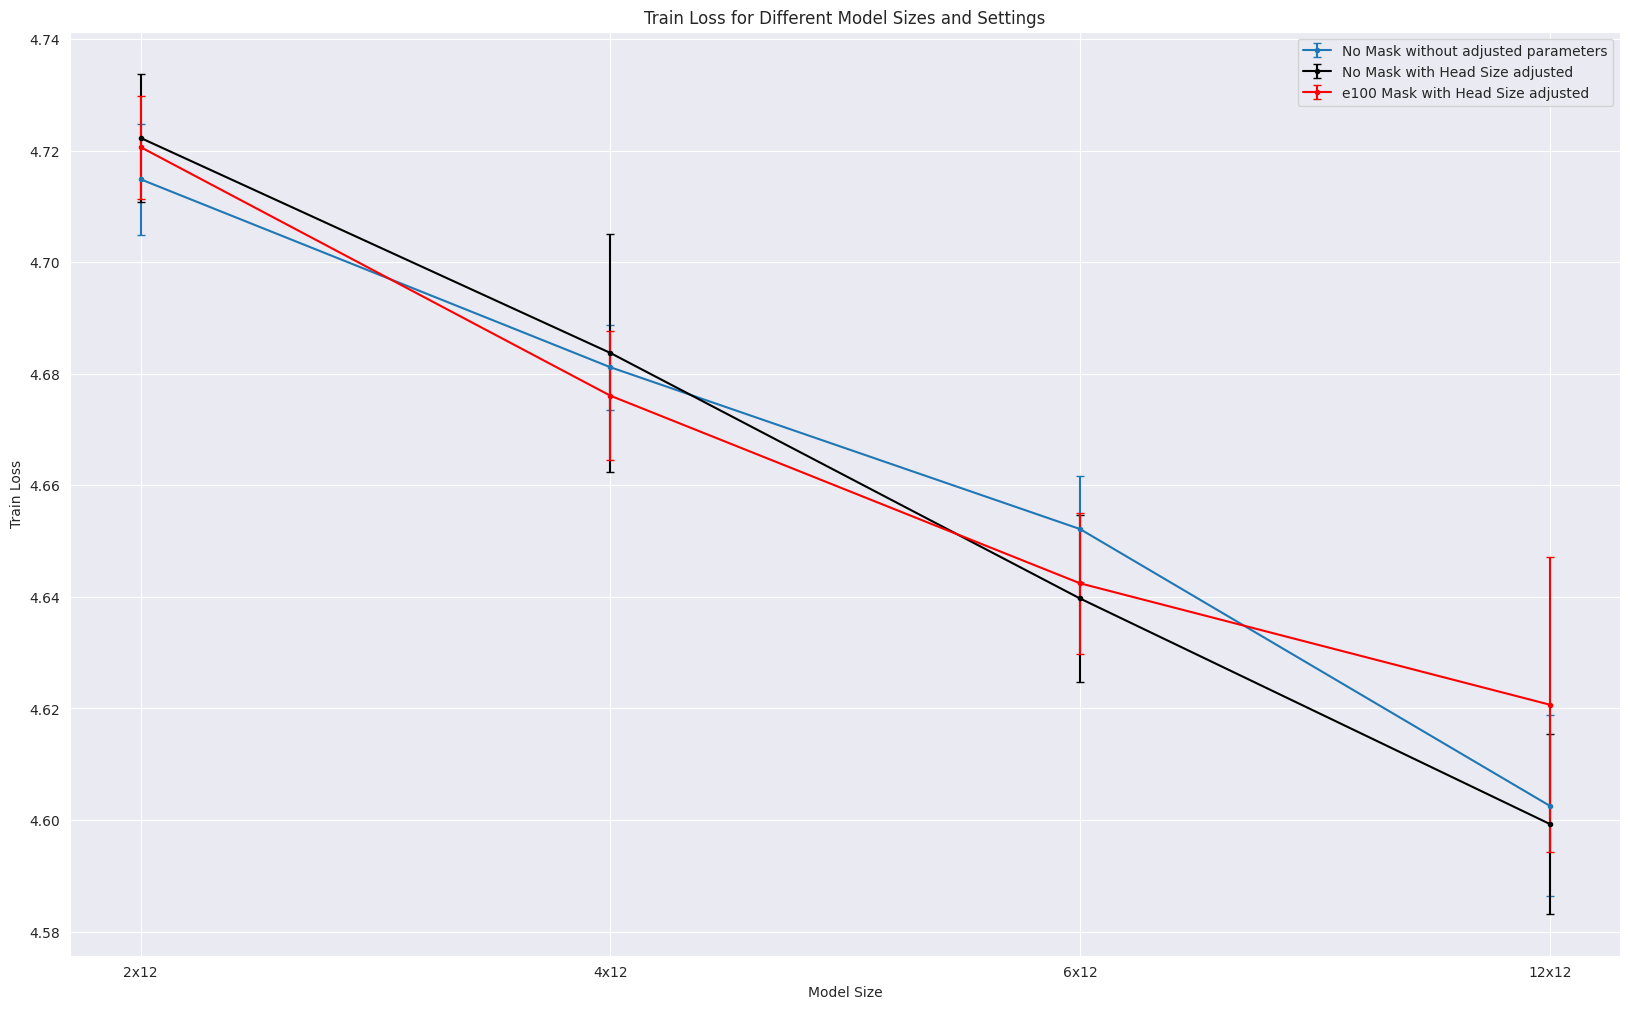

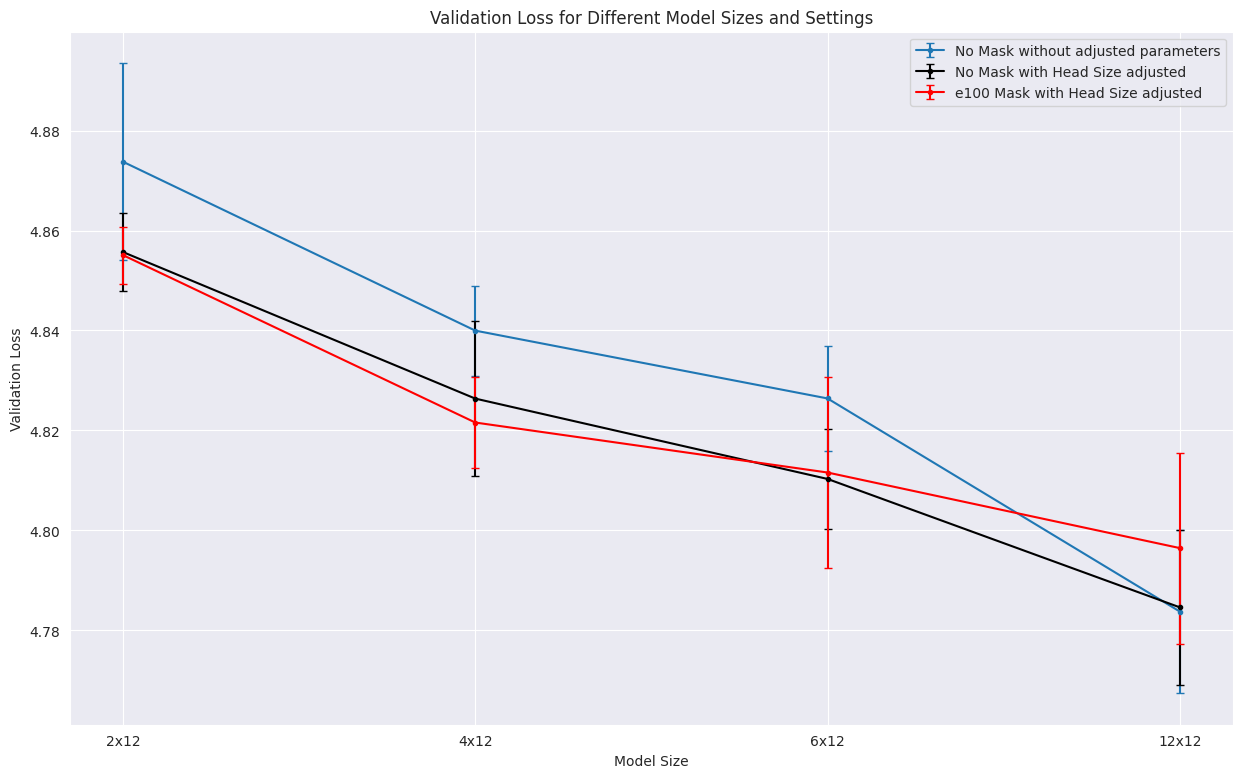

In [23]:
import matplotlib.pyplot as plt
import numpy as np
settings_names = ["No Mask without adjusted parameters", "No Mask with Head Size adjusted",  "e100 Mask with Head Size adjusted"]

setting1_td_mean = setting1_td_arr.mean(axis=1)
setting1_td_std = setting1_td_arr.std(axis=1)

setting2_td_mean = setting2_td_arr.mean(axis=1)
setting2_td_std = setting2_td_arr.std(axis=1)

setting3_td_mean = setting3_td_arr.mean(axis=1)
setting3_td_std = setting3_td_arr.std(axis=1)

setting1_vd_mean = setting1_vd_arr.mean(axis=1)
setting1_vd_std = setting1_vd_arr.std(axis=1)

setting2_vd_mean = setting2_vd_arr.mean(axis=1)
setting2_vd_std = setting2_vd_arr.std(axis=1)

setting3_vd_mean = setting3_vd_arr.mean(axis=1)
setting3_vd_std = setting3_vd_arr.std(axis=1)

# Plotting train data
plt.figure(figsize=(20, 12))

# Plot train data for setting 1
plt.errorbar(model_sizes, setting1_td_mean, yerr=setting1_td_std, label=settings_names[0], fmt='.-', capsize=3)

# # Plot train data for setting 2
plt.errorbar(model_sizes, setting2_td_mean, yerr=setting2_td_std, label=settings_names[1], fmt='.-', capsize=3, color = "black")
#
# # Plot train data for setting 3
plt.errorbar(model_sizes, setting3_td_mean, yerr=setting3_td_std, label=settings_names[2], fmt='.-', capsize=3, color='red')

plt.xlabel('Model Size')
plt.ylabel('Train Loss')
#plt.ylim(4.55,4.75)
plt.title('Train Loss for Different Model Sizes and Settings')
plt.legend()
plt.grid(True)
plt.show()

# Plotting test data
plt.figure(figsize=(15, 9))

# Plot test data for setting 1
plt.errorbar(model_sizes, setting1_vd_mean, yerr=setting1_vd_std, label=settings_names[0], fmt='.-', capsize=3)

# Plot test data for setting 2
plt.errorbar(model_sizes, setting2_vd_mean, yerr=setting2_vd_std, label=settings_names[1], fmt='.-', capsize=3, color = "black")

# Plot test data for setting 3
plt.errorbar(model_sizes, setting3_vd_mean, yerr=setting3_vd_std, label=settings_names[2], fmt='.-', capsize=3,color='red')

plt.xlabel('Model Size')
plt.ylabel('Validation Loss')
#plt.ylim(4.75,4.9)
plt.title('Validation Loss for Different Model Sizes and Settings')
plt.legend()
plt.grid(True)
plt.show()



 No Mask without Adjusted Parameters
                size train_loss  val_loss
log_unique_id                            
6093007         2x12   4.723453  4.891364
6093010         4x12   4.682837  4.826443
6067324         6x12   4.647078   4.80971
6067325        12x12   4.611391  4.784145

 e100 Mask without Adjusted parameters
                size train_loss  val_loss
log_unique_id                            
6093011         2x12   4.799397  4.949916
6093012         4x12   4.740199  4.875053
6076156         6x12   4.708694  4.854651
5990498        12x12   4.663549  4.816848

 e100 Mask with FFW Adj
                size train_loss  val_loss
log_unique_id                            
6156974         2x12   4.649844  4.817045
6156975         4x12   4.615108  4.800871
6156976         6x12   4.613055   4.79181
5990498        12x12   4.663549  4.816848

 e100 Mask with Head Size Adj
                size train_loss  val_loss
log_unique_id                            
6155194         2x12   4.7

/tmp/ipykernel_287143/1953893645.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['size'] = pd.Categorical(filtered_data['size'], model_sizes)


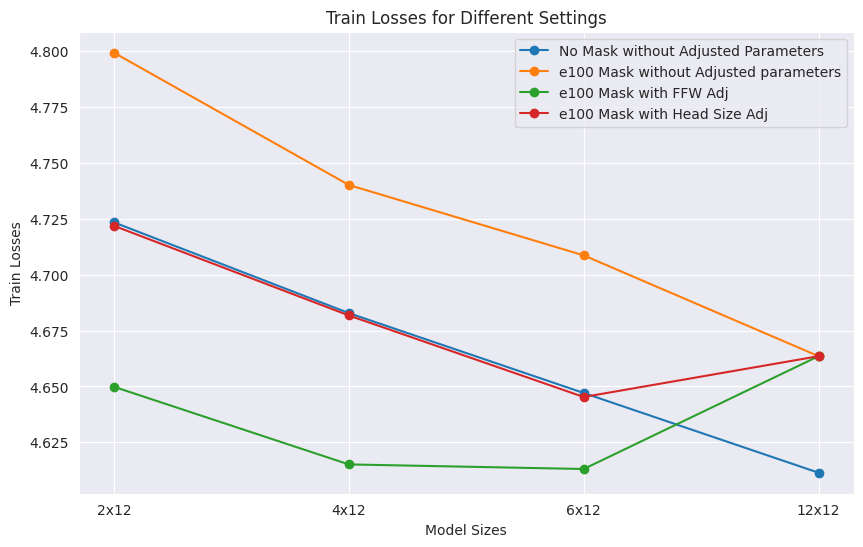

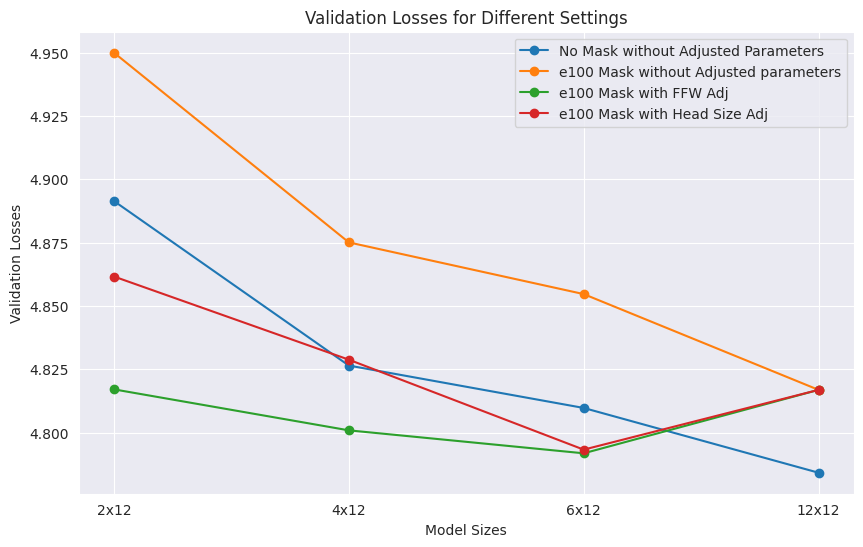

In [123]:
import matplotlib.pyplot as plt

# Filter data based on context type
filtered_data = data_dict_df[data_dict_df['context_type'] == 'short']


# Define the model sizes to include on the x-axis
model_sizes = ['2x12', '4x12', '6x12', '12x12']
filtered_data['size'] = pd.Categorical(filtered_data['size'], model_sizes)
filtered_data = filtered_data.sort_values('size')
settings = ["No Mask without Adjusted Parameters", "e100 Mask without Adjusted parameters", "e100 Mask with FFW Adj", "e100 Mask with Head Size Adj"]

line_chart_1 = [
"train_blmf_8k_2x12_5gramgpt_nomask.py", "train_blmf_8k_4x12_5gramgpt_nomask.py", "train_blmf_8k_6x12_5gramgpt_nomask.py", "train_blmf_8k_12x12_5gramgpt_nomask.py"]#, "train_blmf_8k_16x12_5gramgpt_nomask.py",]
print("\n",settings[0])
print(filtered_data[filtered_data['file_name'].isin(line_chart_1)][["size", "train_loss", "val_loss"]].sort_values(by='size'))


line_chart_2 = [
"train_blmf_8k_2x12_gpt_exp100_short5.py", "train_blmf_8k_4x12_gpt_exp100_short5.py", "train_blmf_8k_6x12_gpt_exp100_short5.py", "train_blmf_8k_12x12_gpt_exp100_short5.py"]#, "train_blmf_8k_16x12_gpt_exp100_short5.py", ]
print("\n",settings[1])
#sorted in order of size
print(filtered_data[filtered_data['file_name'].isin(line_chart_2)][["size", "train_loss", "val_loss"]].sort_values(by='size'))


line_chart_3 = [
"train_blmf_8k_2x12_gpt_exp100_short5_ffwadjp.py", "train_blmf_8k_4x12_gpt_exp100_short5_ffwadjp.py", "train_blmf_8k_6x12_gpt_exp100_short5_ffwadjp.py", "train_blmf_8k_12x12_gpt_exp100_short5_ffwadjp.py"]#, "train_blmf_8k_16x12_gpt_exp100_short5_ffwadjp.py", ]
print("\n",settings[2])
print(filtered_data[filtered_data['file_name'].isin(line_chart_3)][["size", "train_loss", "val_loss"]])

line_chart_4 = ["train_blmf_8k_2x12_gpt_exp100_short5_hsadjp.py", "train_blmf_8k_4x12_gpt_exp100_short5_hsadjp.py", "train_blmf_8k_6x12_gpt_exp100_short5_hsadjp.py", "train_blmf_8k_12x12_gpt_exp100_short5_hsadjp.py"]#, "train_blmf_8k_16x12_gpt_exp100_short5_hsadjp.py", ]
print("\n",settings[3])
print(filtered_data[filtered_data['file_name'].isin(line_chart_4)][["size", "train_loss", "val_loss"]])

line_chart_1_tl_data = [(row["size"],row["train_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_1)].to_dict(orient='records')]
line_chart_1_vl_data = [(row["size"],row["val_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_1)].to_dict(orient='records')]
line_chart_2_tl_data = [(row["size"],row["train_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_2)].to_dict(orient='records')]
line_chart_2_vl_data = [(row["size"],row["val_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_2)].to_dict(orient='records')]
line_chart_3_tl_data = [(row["size"],row["train_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_3)].to_dict(orient='records')]
line_chart_3_vl_data = [(row["size"],row["val_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_3)].to_dict(orient='records')]
line_chart_4_tl_data = [(row["size"],row["train_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_4)].to_dict(orient='records')]
line_chart_4_vl_data = [(row["size"],row["val_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_4)].to_dict(orient='records')]


train_loss_lists = [line_chart_1_tl_data, line_chart_2_tl_data, line_chart_3_tl_data, line_chart_4_tl_data]
val_loss_lists = [line_chart_1_vl_data, line_chart_2_vl_data, line_chart_3_vl_data, line_chart_4_vl_data]


plt.figure(figsize=(10, 6))

# Plot each list of tuples
for i, loss_list in enumerate(train_loss_lists, 1):
    losses = [pair[1] for pair in loss_list]  # Extract y-values (losses)
    print(losses)
    plt.plot(model_sizes, losses, marker='o', label=settings[i-1])

# Set labels and title, add legend
plt.xlabel('Model Sizes')
plt.ylabel('Train Losses')
plt.title('Train Losses for Different Settings')
plt.legend()

# Show the plot
plt.show()

# Create a new figure for validation losses
plt.figure(figsize=(10, 6))

for i, loss_list in enumerate(val_loss_lists, 1):
    losses = [pair[1] for pair in loss_list]  # Extract y-values (losses)
    plt.plot(model_sizes, losses, marker='o', label=settings[i-1])

# Set labels and title, add legend
plt.xlabel('Model Sizes')
plt.ylabel('Validation Losses')
plt.title('Validation Losses for Different Settings')
plt.legend()

# Show the plot
plt.show()


 No Mask without adjusted parameters
                size train_loss  val_loss
log_unique_id                            
6093007         2x12   4.723453  4.891364
6093010         4x12   4.682837  4.826443
6067324         6x12   4.647078   4.80971
6067325        12x12   4.611391  4.784145
6067326        16x12   4.582759  4.770971

 e100 Mask without Adjusted parameters
                size train_loss  val_loss
log_unique_id                            
6093011         2x12   4.799397  4.949916
6093012         4x12   4.740199  4.875053
6076156         6x12   4.708694  4.854651
5990498        12x12   4.663549  4.816848
6076157        16x12   4.645685  4.818047

 e100 Mask with FFW Adj
                size train_loss  val_loss
log_unique_id                            
6156974         2x12   4.649844  4.817045
6156975         4x12   4.615108  4.800871
6156976         6x12   4.613055   4.79181
5990498        12x12   4.663549  4.816848
6156977        16x12   4.610767  4.810141

 e100 Mask wit

/tmp/ipykernel_287143/3896424719.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['size'] = pd.Categorical(filtered_data['size'], model_sizes)


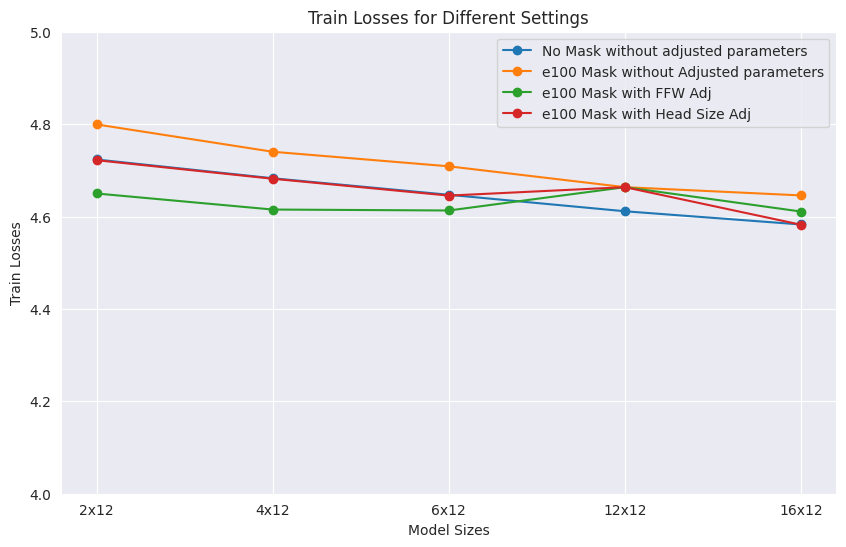

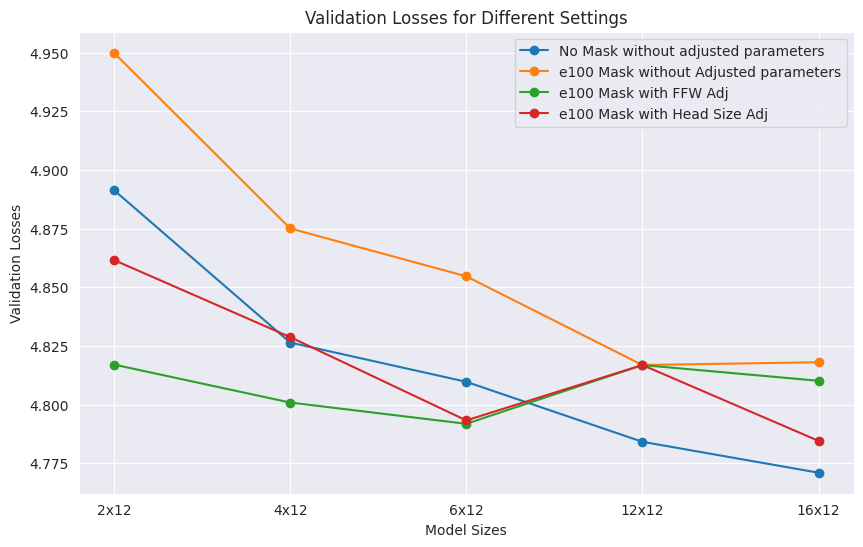

In [121]:
import matplotlib.pyplot as plt

# Filter data based on context type
filtered_data = data_dict_df[data_dict_df['context_type'] == 'short']


# Define the model sizes to include on the x-axis
model_sizes = ['2x12', '4x12', '6x12', '12x12', '16x12']
filtered_data['size'] = pd.Categorical(filtered_data['size'], model_sizes)
filtered_data = filtered_data.sort_values('size')
settings = ["No Mask", "Mask without Adjusted parameters", "Mask with FFW Adj", "Mask with head size Adj"]

line_chart_1 = [
"train_blmf_8k_2x12_5gramgpt_nomask.py", "train_blmf_8k_4x12_5gramgpt_nomask.py", "train_blmf_8k_6x12_5gramgpt_nomask.py", "train_blmf_8k_12x12_5gramgpt_nomask.py", "train_blmf_8k_16x12_5gramgpt_nomask.py",
]
print("\n",settings[0])
print(filtered_data[filtered_data['file_name'].isin(line_chart_1)][["size", "train_loss", "val_loss"]].sort_values(by='size'))


line_chart_2 = [
"train_blmf_8k_2x12_gpt_exp100_short5.py", "train_blmf_8k_4x12_gpt_exp100_short5.py", "train_blmf_8k_6x12_gpt_exp100_short5.py", "train_blmf_8k_12x12_gpt_exp100_short5.py", "train_blmf_8k_16x12_gpt_exp100_short5.py",
]
print("\n",settings[1])
#sorted in order of size
print(filtered_data[filtered_data['file_name'].isin(line_chart_2)][["size", "train_loss", "val_loss"]].sort_values(by='size'))


line_chart_3 = [
"train_blmf_8k_2x12_gpt_exp100_short5_ffwadjp.py", "train_blmf_8k_4x12_gpt_exp100_short5_ffwadjp.py", "train_blmf_8k_6x12_gpt_exp100_short5_ffwadjp.py", "train_blmf_8k_12x12_gpt_exp100_short5_ffwadjp.py", "train_blmf_8k_16x12_gpt_exp100_short5_ffwadjp.py",
]
print("\n",settings[2])
print(filtered_data[filtered_data['file_name'].isin(line_chart_3)][["size", "train_loss", "val_loss"]])

line_chart_4 = ["train_blmf_8k_2x12_gpt_exp100_short5_hsadjp.py", "train_blmf_8k_4x12_gpt_exp100_short5_hsadjp.py", "train_blmf_8k_6x12_gpt_exp100_short5_hsadjp.py", "train_blmf_8k_12x12_gpt_exp100_short5_hsadjp.py", "train_blmf_8k_16x12_gpt_exp100_short5_hsadjp.py",
]
print("\n",settings[3])
print(filtered_data[filtered_data['file_name'].isin(line_chart_4)][["size", "train_loss", "val_loss"]])

line_chart_1_tl_data = [(row["size"],row["train_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_1)].to_dict(orient='records')]
line_chart_1_vl_data = [(row["size"],row["val_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_1)].to_dict(orient='records')]
line_chart_2_tl_data = [(row["size"],row["train_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_2)].to_dict(orient='records')]
line_chart_2_vl_data = [(row["size"],row["val_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_2)].to_dict(orient='records')]
line_chart_3_tl_data = [(row["size"],row["train_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_3)].to_dict(orient='records')]
line_chart_3_vl_data = [(row["size"],row["val_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_3)].to_dict(orient='records')]
line_chart_4_tl_data = [(row["size"],row["train_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_4)].to_dict(orient='records')]
line_chart_4_vl_data = [(row["size"],row["val_loss"]) for row in filtered_data[filtered_data['file_name'].isin(line_chart_4)].to_dict(orient='records')]


train_loss_lists = [line_chart_1_tl_data, line_chart_2_tl_data, line_chart_3_tl_data, line_chart_4_tl_data]
val_loss_lists = [line_chart_1_vl_data, line_chart_2_vl_data, line_chart_3_vl_data, line_chart_4_vl_data]


plt.figure(figsize=(10, 6))

# Plot each list of tuples
for i, loss_list in enumerate(train_loss_lists, 1):
    losses = [pair[1] for pair in loss_list]  # Extract y-values (losses)
    print(losses)
    plt.plot(model_sizes, losses, marker='o', label=settings[i-1])

# Set labels and title, add legend
plt.xlabel('Model Sizes')
plt.ylabel('Train Losses')
plt.title('Train Losses for Different Settings')
plt.legend()
#Set y axis start to 0
plt.ylim(4, 5)
# Show the plot
plt.show()

# Create a new figure for validation losses
plt.figure(figsize=(10, 6))

for i, loss_list in enumerate(val_loss_lists, 1):
    losses = [pair[1] for pair in loss_list]  # Extract y-values (losses)
    plt.plot(model_sizes, losses, marker='o', label=settings[i-1])

# Set labels and title, add legend
plt.xlabel('Model Sizes')
plt.ylabel('Validation Losses')
plt.title('Validation Losses for Different Settings')
plt.legend()

# Show the plot
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (20,).

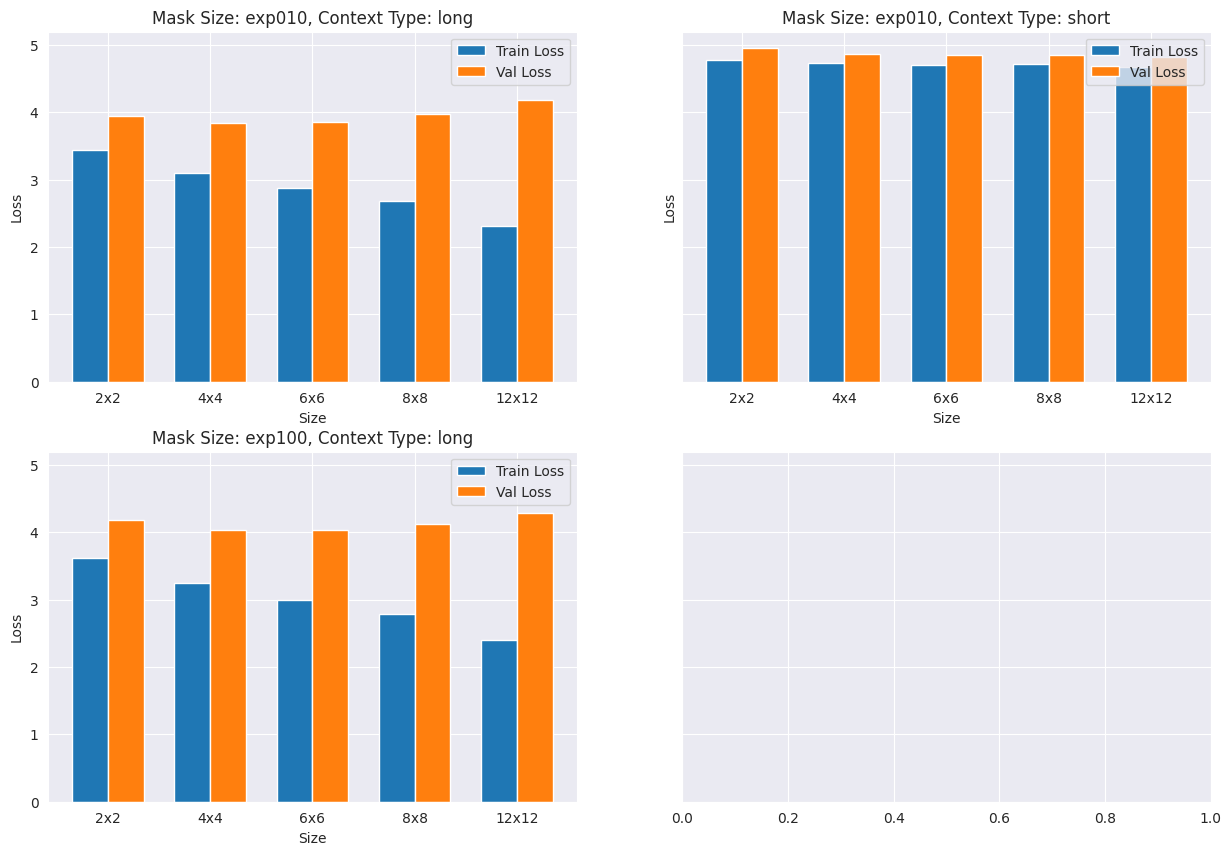

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define mask sizes and context types
mask_sizes = ['exp010', 'exp100']
context_types = ['long', 'short']

# Create subplots for each combination of mask size and context type
fig, axs = plt.subplots(len(mask_sizes), len(context_types), figsize=(15, 10), sharey=True)

# Iterate over mask sizes and context types
for i, mask_size in enumerate(mask_sizes):
    for j, context_type in enumerate(context_types):
        # Filter data based on mask size and context type
        filtered_data = data_dict_df[(data_dict_df['mask_size'] == mask_size) & (data_dict_df['context_type'] == context_type)]

        # Get unique sizes
        sizes = filtered_data['size'].unique()

        # Define bar width
        bar_width = 0.35
        index = np.arange(len(sizes))

        # Plot train and val loss for each size
        axs[i, j].bar(index, filtered_data['train_loss'], bar_width, label='Train Loss')
        axs[i, j].bar(index + bar_width, filtered_data['val_loss'], bar_width, label='Val Loss')

        # Set labels and title
        axs[i, j].set_xlabel('Size')
        axs[i, j].set_ylabel('Loss')
        axs[i, j].set_title(f'Mask Size: {mask_size}, Context Type: {context_type}')
        axs[i, j].set_xticks(index + bar_width / 2)
        axs[i, j].set_xticklabels(sizes)
        axs[i, j].legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define mask sizes and context types
mask_sizes = ['exp010', 'exp100']
context_types = ['long', 'short']

# Create subplots for each combination of mask size and context type
fig, axs = plt.subplots(len(mask_sizes), len(context_types), figsize=(15, 10), sharey=True)

# Iterate over mask sizes and context types
for i, mask_size in enumerate(mask_sizes):
    for j, context_type in enumerate(context_types):
        # Filter data based on mask size and context type
        filtered_data = data_dict_df[(data_dict_df['mask_size'] == mask_size) & (data_dict_df['context_type'] == context_type)]

        # Get unique sizes
        sizes = filtered_data['size'].unique()

        # Define bar width
        bar_width = 0.35
        index = np.arange(len(sizes))

        # Plot train and val loss for each size
        bars_train = axs[i, j].bar(index, filtered_data['train_loss'], bar_width, label='Train Loss')
        bars_val = axs[i, j].bar(index + bar_width, filtered_data['val_loss'], bar_width, label='Val Loss')

        # Set labels and title
        axs[i, j].set_xlabel('Size')
        axs[i, j].set_ylabel('Loss')
        axs[i, j].set_title(f'Mask Size: {mask_size}, Context Type: {context_type}')
        axs[i, j].set_xticks(index + bar_width / 2)
        axs[i, j].set_xticklabels(sizes)
        axs[i, j].legend()

        # Add values on top of each bar
        for bar in bars_train:
            height = bar.get_height()
            axs[i, j].text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')
        for bar in bars_val:
            height = bar.get_height()
            axs[i, j].text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

        # Set slightly higher upper limit for y-axis
        ylim = axs[i, j].get_ylim()
        axs[i, j].set_ylim(ylim[0], ylim[1] * 1.08)
plt.tight_layout()
